# Analysis and comparison of the Lomb-Scargle and cubic interpolation methods for use on irregularly sampled voltage data


In [ ]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import lombscargle


# Introduction



Electrical power systems play an important role in modern society and are vital for communication, transport and technological advancement. [1] The maintenance and quality of the power flowing through our infrastructure is critical with a substantial amount of research being done in this field. One of the many things that can affect the quality of electrical power is the presence of harmonics. A harmonic is an integer multiple of the fundamental frequency present in an electrical signal and is created when a device in a power system draws non- linear loads [1]  The presence of harmonics in a system can cause other components in the system such as motors, transformers and generators to degrade and eventually fail due to thermal damage. [2] Due to dangers posed by overheating components and national regulations, it is vital that engineers are able to identify and quantify the harmonic content of an electrical system to deduce the quality of the signal.

The metric used to measure the quality of a signal is known as the total harmonic distortion (THD) and it is a numerical representation of how much a signal deviates from a sinusoidal shape. It is calculated as a sum of all of the harmonics over the fundamental frequency and is expressed as a percentage. As per regulations, all commercial systems are required to have a THD less than 5%.[3]

Both the THD and Harmonic identification rely heavily on regularly sampled data as the main method used to identify Harmonics is the Fast Fourier Transform [4], which assumes data is composed of evenly spaced samples. However, in practical applications, data stemming from electrical power systems may not be regularly sampled due to communication issues such as packet loss or dropouts or hardware limitations in the systems such as components having differing clock speeds. [5] Engineers need to be able to perform harmonic analysis on data regardless of the quality of the data and there are multiple ways they achieve this.

This report will compare two methods of calculating the THD for a real world signal using irregularly sampled data. These methods will be FFT through cubic interpolation and the Lomb_scargle periodogram. Both methods are frequently used in multiple industries to produce frequency spectrum diagrams from irregularly sampled data [6].



# 1: Method

# 1.1 : Fundemental functions


To create an algorithm capable of identifying harmonics in a signal, a synthetic dataset had to be created.This dataset was made using the formula for a sinusoidal wave:

$$
V(t) = V_m \sin(2\pi f t )                                               
$$

and was primarily used to test and calibrate the FFT and peak finding functions. The function below can be called with parameters A, f1 and t, representing the amplitude, fundemental frequency and time duration. In this case, the amplitude and fundamental frequency of the signal represent the voltage and operating frequency of the electrical signal that is being modelled. [7]



In [ ]:
#signal generation
def signal_generator (A,f1,t):
    """
   A function that creates a synthetic electrical signal

    Parameters:

    A : amplitude of the wave which corresponds to the voltage
    f1 : fundemental frequency in Hz
    t : time duration in seconds

    Returns: a sine wave with frequency f1

    """
    return A*np.sin(2 * np.pi * f1 * t) # generates the fundemental signal



When an electrical signal is created or imported into the program, its data exists in the time domain with the signal being a set of times on the x axis, and a set of voltage values on the y axis. Looking at the data this way, it can be difficult to see exactly where the harmonic content is,  especially if the harmonics are magnitudes smaller than the fundamental frequency. To be able to properly isolate the harmonics, the data needs to be shifted into the frequency domain [8]. To do this, the Fast Fourier Transform (FFT) is used. The spectral analysis diagrams produced by using the FFT is the primary method used to identify harmonic phenomenon in industry [9] and will be used here as the baseline value to compare against the values calculated using the other methods later on. The function below, which performs the FFT, uses the scipy library to increase the accuracy of the final calculation. It can be called with a t_vec, the vector time series which corresponds to the times that the data was recorded at, signal, which represents the sinusoidal power signal in the time domain, and sample_freq, which is the sampling frequency of the signal. The FFT values and frequencies are calculated and then stripped to only include the positive (absolute) values. This is done as both the positive and negative values will be mirrors of each other and as this is a real world application, only the positive values correspond to actual amplitudes of each frequency component.[10]

In [ ]:
#fft transformation funciton
def fft_transfrom (t_vec,signal,sample_freq):
    """
    A function that performs a Fast Fourier transformation on a signal

    Parameters:

    t_vec : the time vector for the given signal (s)
    signal : the signal that is to be transformed
    sample_freq : the sampling frequency of the signal


    Returns: list of positive frequencies and list of positive FFT transformed data
    """



    N = len(t_vec) # number of samples

    fft_val = np.fft.fft(signal) # fourier transformed values
    frequencies = np.fft.fftfreq(N,1/sample_freq) #fourier transformed frequencies

    #only taking positive values
    positive_frequencies = frequencies[:N//2]
    positive_fft = np.abs(fft_val[:N // 2])


    return (positive_frequencies, positive_fft)






Once the data has been transformed, the harmonics present need to be identified. To do this, a peak finding algorithm was created. This algorithm truncates the data to focus on the sections with the harmonic content, and then splits the data points into separate arrays of set sizes based on the interval size specified when calling the function. It then iterates through each array chunk and appends the maximum value present to the output list.

In [ ]:
#peak finding
def peak_finding (datapoints,interval,end):
    """
    A function that locates the local maximum point in a set interval size

    Parameters:

    datapoints : array of datapoints to be analysed
    interval : integer size of the interval to split the data up
    end : integer endpoint


    Returns: list of peak values
    """

    peak_amps = []

    #truncating data
    datapoints_stripped = datapoints[:end]

    #splitting data into chunks
    intervals =  [datapoints_stripped[i:i + interval] for i in range(0, len(datapoints_stripped), interval)]

    #finding the maximum point in each chunk
    for i, chunk in enumerate(intervals):
        peak_amps.append(np.max(chunk))

    #returns list of maximum points
    return peak_amps


With the peak values identified and the data points transformed into the frequency domain, a function is called to plot the data to visualise where each harmonic is. Plotting the data is an essential step as it allows for the corrections and adjustment of the interval that is used to calculate the Peak_amps list. The function below takes in the x and y axis values, which represent a list of frequencies on the x axis and a list of amplitude readings on the y axis, and a list of the peak values which corresponds to the harmonics present including the fundamental harmonic. The function then plots a frequency spectrum graph and labels the numerical value of each significant peak with a horizontal line.

In [ ]:
#visualisation
def Visualise_freq_spectrum (x,y,peaks):
    """
    A function that plots a frequency spectrum graph and all its peaks

    Parameters:

    x : x values as an array
    y : y values as an array
    Threshold : threshold frequency for peak values to surpass
    peaks : a list of all peaks present in the graph

    """

    #plotting the frequency
    plt.plot(x,y)
    plt.title('Frequency spectrum analysis')
    plt.xlabel('Frequency (Hz)')


    #plotting lines for the peak amplitudes
    cmap = plt.cm.get_cmap('viridis', len(Peak_amps)) # creating a color map so each line can have its own color

    for idx, i in enumerate(peaks):
        plt.axhline(y=i, color=cmap(idx), linestyle='-', label=str(i)) # plotting the lines to show the peak amplitides



After visualization and confirmation that each peak is accounted for, The Total Harmonic Distortion (TDH) of the signal can be calculated. The THD is a measure of how much of a signal is comprised of unwated harmonic content and is essentially calculated as a ratio of the sum of all the unwanted harmonics to the fundamental frequency. The formula for THD is [11] :

$$
\text{THD} = \frac{\sqrt{\sum_{k=2}^{\infty} |A_k|^2}}{|A_1|} \times 100\%
$$

The function below takes an array of harmonics including the fundamental, identifying the fundamental ,which is the largest or maximum value in the array, and calculates the THD by using the formula above. It then expresses the harmonic distortion as a percentage.

In [ ]:
import numpy as np

#THD calculation using amplitude
def calc_THD (harmonics):
    """
    A function that calculates the total harmonic distortion of a signal

    Parameters:

    harmonics : a list of the significant amplitudes present in a signal including the fundemental

    Returns: Total harmonic distoriton as a percentage
    """
    RMS = [] # variable to store the RMS values

    # Identifying the fundemental amplitude
    harmonics.sort()
    max_amp = harmonics[-1] / (np.sqrt(2)) # converting the amplitude to RMS

    # converting the harmonic amplitudes to RMS
    for i in harmonics [:-1]:
        RMS.append (( i / (np.sqrt(2))) **2)

    # calculating THD
    THD = ((np.sqrt(sum(RMS))) /max_amp ) * 100

    return(THD)


With a baseline value set using regularly sampled data, the next step is to transform the regularly sampled data into irregularly sampled data to test how different methods cope with missing values. To modify any given signal, the function below was created. It can be called with the parameters times, values and percent. Times and values correspond to the arrays of times and measured values that originate from the electrical signal while percent is a numerical input representing how much of the signal is to be retained. For example, a percent value of 80 would return a signal that is 80% complete. The function creates an irregularly sampled signal by randomly removing a set amount of data points from both lists, simulating random packet loss or sensor malfunctions [5].

In [ ]:
#conversion from regular to irregular sampling
def regular_to_irregular (times,values,points):
    """
    A function that takes a regularly sampled signal and returns an irregularlt sampled signal with a set amount of poins

    Parameters:

    times: an array of time values
    values: an array of datapoints corresponding to the times
    percent: a float between 0 and 1 corresponding to the percentage of the signal returned


    Returns: an array of irregularly spaced data and corresponding times

    """
    #calculating the number of points to return from the dataset


    #randomly selecting the points to return
    irregular_indices = np.sort(np.random.choice(len(times), points, replace=False))
    irregular_times = times[irregular_indices]
    irregular_values = values[irregular_indices]

    return(irregular_times,irregular_values)


# 1.2 : Methods for irregular sampling

After acquiring irregularly sampled data, the two methods of shifting irregularly sampled data into the frequency domain can be introduced. These methods are Interpolation and the Lomb Scargle method. both these methods are used for various signal processing applications. [6] The first method, Interpolation, uses the presence of neighbouring data points to to estimate the values for missing data points. One of the main benefits to this method is that after the data has been "fixed" it can be run through the same FFT algorithm that was defined above and used to transform the uniformly sampled data. The second method, the Lomb Scargle, is a seemingly more powerful tool that fits a sinusoidal shape over the existing data using a weighted least squares approach with the weights being calculated using the time interval between points [12].

The interpolation method is described below as a function that takes arrays of times and values and returns a set of interpolated values. The specific method of interpolation used here is cubic interpolation which fits a cubic curve to every set of four data points. This method was chosen over others as a cubic curve creates a smooth curve through the data points which can more accurately represent the shape of a sinusoidal wave. Additionally, the continuity of cubic polynomials ensures that the transitions between data points is clean which results in an overall cleaner FFT. The parameter fill_value="extrapolate" is also used to ensure any points on the edges of the dataset that may be missing can be filled in using the general pattern that is observed in the points preceding it which adds to the overall accuracy of the resulting interpolated signal.[13] The function irregular_interpolation below also has built-in error handling as it clips the data here to ensure that the returned data cant exceed the maximum time period of the original data but in this specific case, that portion of code is redundant.


In [ ]:
# linear interpolation method
def irregular_interpolation(times, values):
    """
    A function that uses linear interpolation to reconstruct a signal

    Parameters:

    times: an array of time data
    values: an array of measurements corresponding to the times


    Returns: a list of interpolated values

    """

    # setting and clipping the times to ensure they stay within the set range (redundant)
    x_min = np.min(times)
    x_max = np.max(times)
    clipped_times = np.clip(times, x_min, x_max)

    # Create cubic interpolator
    interpolator = interp1d(clipped_times, values, kind='cubic', fill_value="extrapolate")

    # Interpolated values at the new time points
    new_time = np.arange(0, len(times), 0.1)
    interpolated_values = interpolator(new_time)

    return interpolated_values


The second method is the Lomb - Scargle Periodogram. This method does not rely on any kind of interpolation and is widely used in many fields such as astronomy where it is used on periodic signals [14] and geophysics for the detection of earthquakes [15]. In the context of electrical engineering, it is another industry method used to detect harmonic content in power systems. This method is primarily used when large portions of data are missing, an area where interpolation may fail due to an insufficient number of points. The function below is an implementation of the Lomb-Scargle method, with parameters that define the upper and lower limits of detection and sampling frequency. The code below also plots the graph and returns an array of peak values to use for the calculation of the THD

In [ ]:
#Lomb-Scargle Visualisation
def Plot_Lomb_Scargle (x,y,interval,end,fmax,resolution,fmin = 0.1):
    """

    A function that computes , plots and calculates the peaks of a givendataset using the Lomb_Scargle method


    Parameters:

    x: time data in array format
    y: measurement values in array format
    end: endpoint of data calculation for peak values
    fmax : integer maximum frequency
    resolution: max sampling resoltion of the x axis
    fmin: integer minimum frequency (default 0.1)

    Returns: Lomb-Scargle values , angular frequencies


    """


    # calculating angular frequencies
    frequencies = np.linspace(fmin, fmax, resolution)

    #calling the Lomb-Scargle scipy function
    Pxx = lombscargle(x, y, frequencies)

    #plotting
    plt.plot(Pxx)

    #peak value calculation
    Peak_amps = peak_finding(Pxx,interval,end)

    #plotting lines for the peak amplitudes
    cmap = plt.cm.get_cmap('viridis', len(Peak_amps)) # creating a color map so each line can have its own color

    for idx, i in enumerate(Peak_amps):
        plt.axhline(y=i, color=cmap(idx), linestyle='-', label=str(i)) # plotting the lines to show the peak amplitide

    return Peak_amps

Finally, since the Lomb-Scargle returns a set of values with power on the y axis, a slightly different equation is required to calculate the THD. The equation is similar to the previous one but uses power instead, utilizing the formula [16]:


$
\text{THD} = \sqrt{\frac{\sum_{n=2}^N P_n}{P_1}}
$


The function below is a simple implementation of this formula. It takes a set of peak values, sorts them in decending order so the largest value is first, isolates the fundemental power and then calculates the THD returning it as a percentage again.

In [ ]:
#THD calculation using power
def TDH_Lomb_Scargle(data):
    """
    Calculates Total Harmonic Distortion (THD) using Lomb-Scargle power spectrum.

    Parameters:
    - data: Array of power values from Lomb-Scargle periodogram

    Returns:
    - THD as a percentage
    """

    #sort data
    data.sort(reverse=True)

    #extract fundemental
    p1 = data[0]


    harmonics = sum (data[1:])

    THD = np.sqrt(harmonics/p1)




    return THD*100


# 1.3 : Generating a synthetic signal and testing


With all the functions defined, the next step is to test and calibrate the code. As mentioned previously, this was done using a synthetic data set. The processes employed here serve as an explanation for the methods used on the real data set later on.

To begin, some initial constants were declared. To keep the graphs and calculations simple, a time duration of 1 second was chosen alongside a sampling frequency of 1000Hz and a fundamental frequency of 50Hz which closely models common appliances. [17]

In [ ]:
sample_freq = 1000 # sampling frequency (Hz)
f1 = 50 # fundamental frequency (Hz)
T = 1 # duration (s)

#time vector
t_vec = np.linspace(0,T,int(sample_freq*T))


the primary (clean) signal (V1) was created by calling the signal_generator function using the constants above. two harmonics were also generated (V2 and V5) which correspond to a second and fifth order harmonic respectively. These were generated using the formula:

$$
V(t) = V_m \sin(2\pi (f*n) t  )
$$

Where n represents the order of the harmonic. The harmonics are then combined with the fundamental signal to create a clean signal which then has some gaussian noise added over it to better simulate real world conditions. [7]




Text(0, 0.5, 'Voltage(V)')

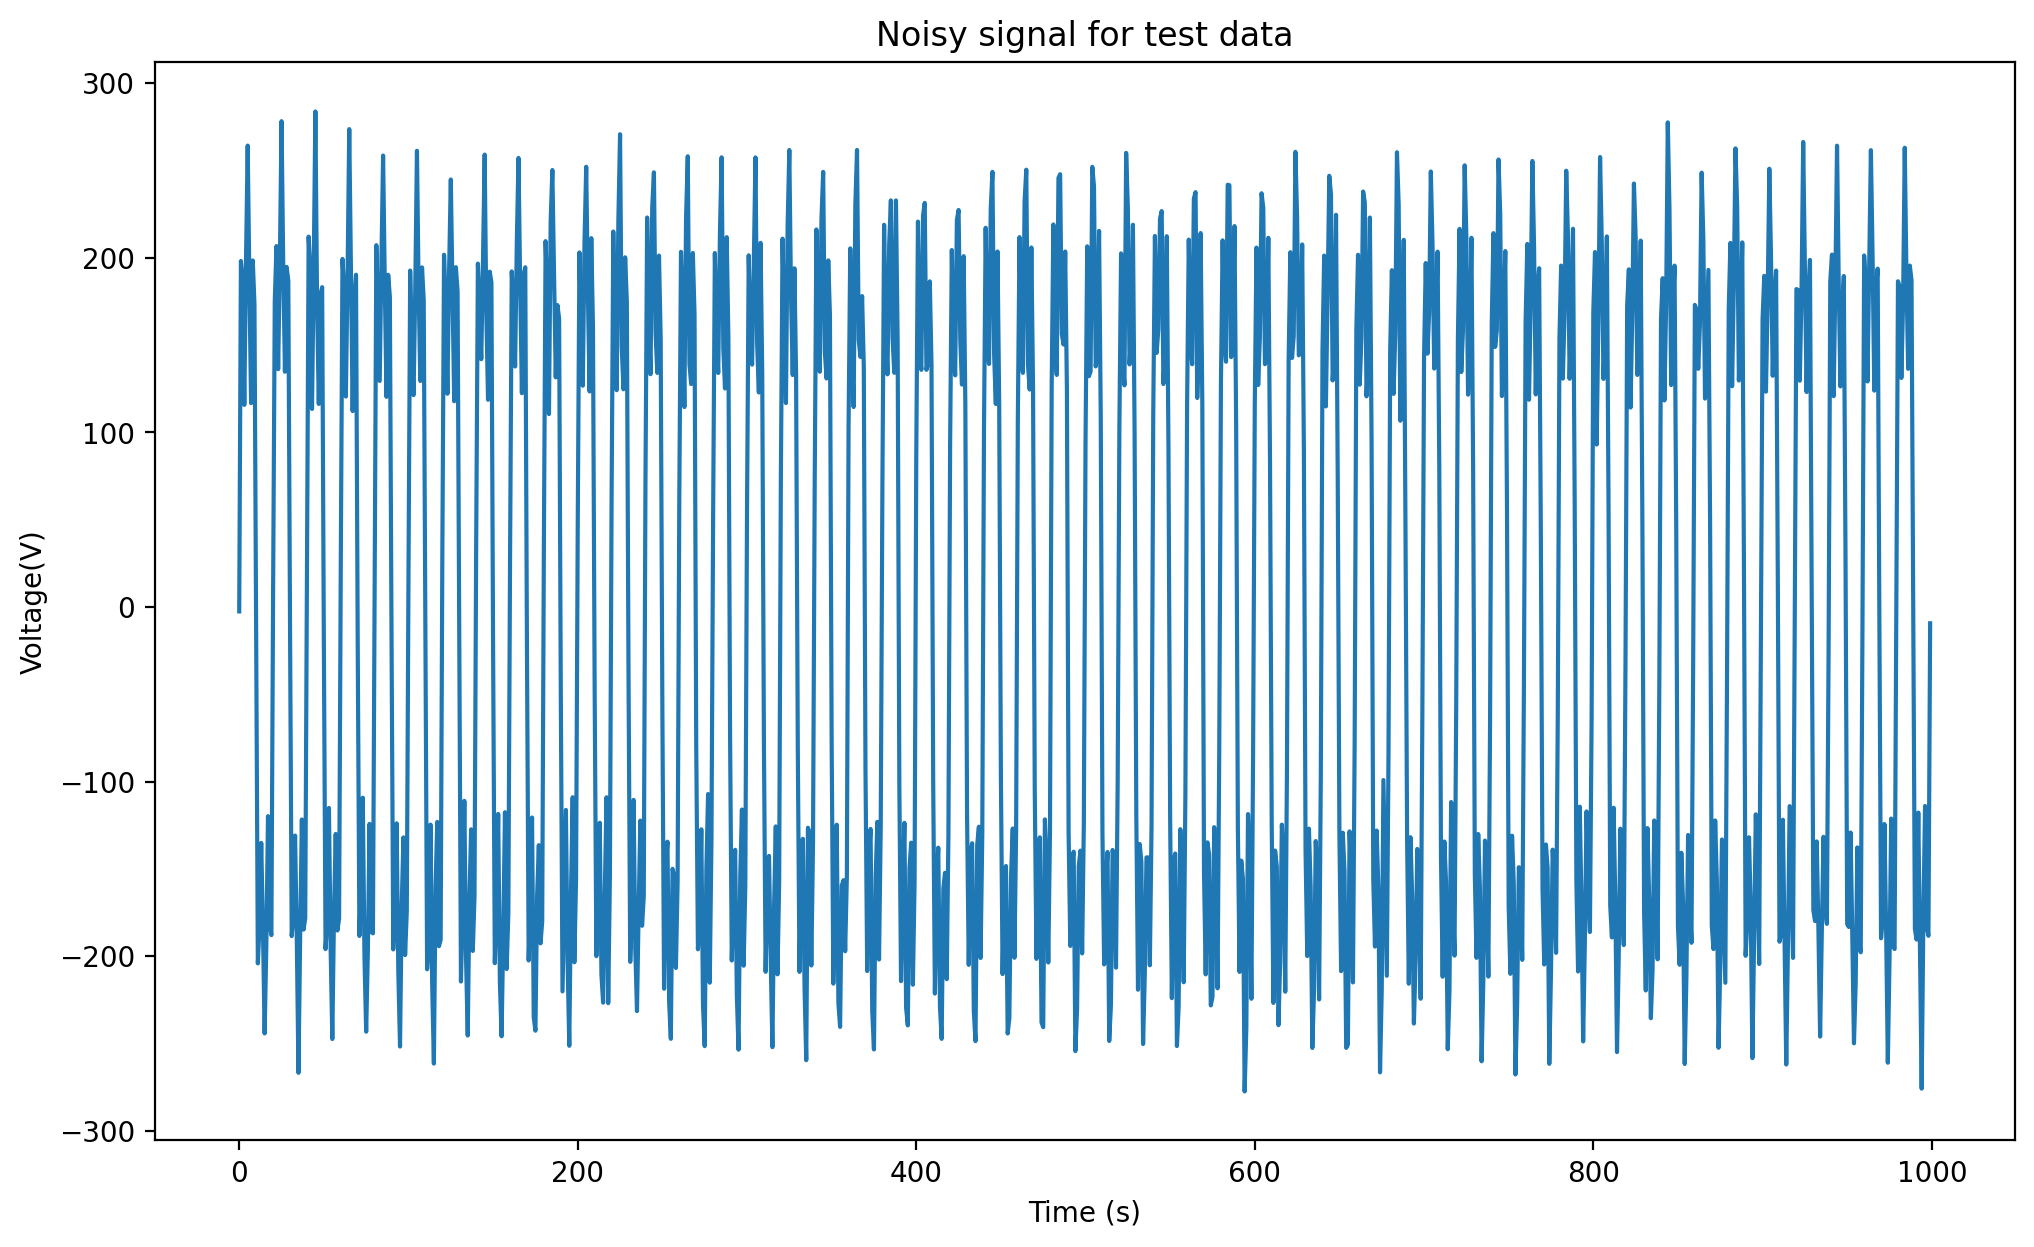

In [ ]:
# creating harmonics

V1 = signal_generator(230,f1,t_vec) # calling the signal generation function at 230v

V2 = 50*np.sin(2 * np.pi * 3 * f1 * t_vec) # creating a third harmonic at 50V

V5 = 80*np.sin(2 * np.pi * 5 * f1 * t_vec) # creating a fifth harmonic at 80V


Clean_signal = V1 + V2 + V5  # compositing the full signal


# noise generation

noise = np.random.normal(0,10,len(t_vec)) # generating noise for the duration of the signal

Noisy_signal = Clean_signal + noise # adding noise to the clean signal







plt.plot(Noisy_signal) # plotting the noisy signal
plt.title("Noisy signal for test data")
plt.xlabel("Time (s)")
plt.ylabel("Voltage(V)")

Above, the noisy signal with harmonics can be seen. It is clearly visible on the graph that the maximum voltage values on the y axis surpass the 230V limit that was specified in the code. This distortion is caused by the noise and harmonics and is a visual marker of the presence of harmonic content in a system.

The next step is to convert the Voltage/Time data above into Amplitude / Frequency data. The fft_transform function defined earlier is called using the noisy signal from above. The peak finding function was also called to locate the harmonics with the result stored in Peak_amps. the combination of Peak_amps and the x and y arrays generated by the FFT transformation were then used in calling the visualisation function which  plotted  the graph.

In the below graph, we can clearly see the fundamental frequency, sitting at 50Hz and the two expected harmonics V2 and V5 which we created. This graph proves that the functions defined above work as intended.

the amplitude of the fundemnetal frequency is: 114367.66109329824
the amplitudes of the harmonics are: [24252.17213068444, 35726.80295239042]


Text(0, 0.5, 'Amplitude')

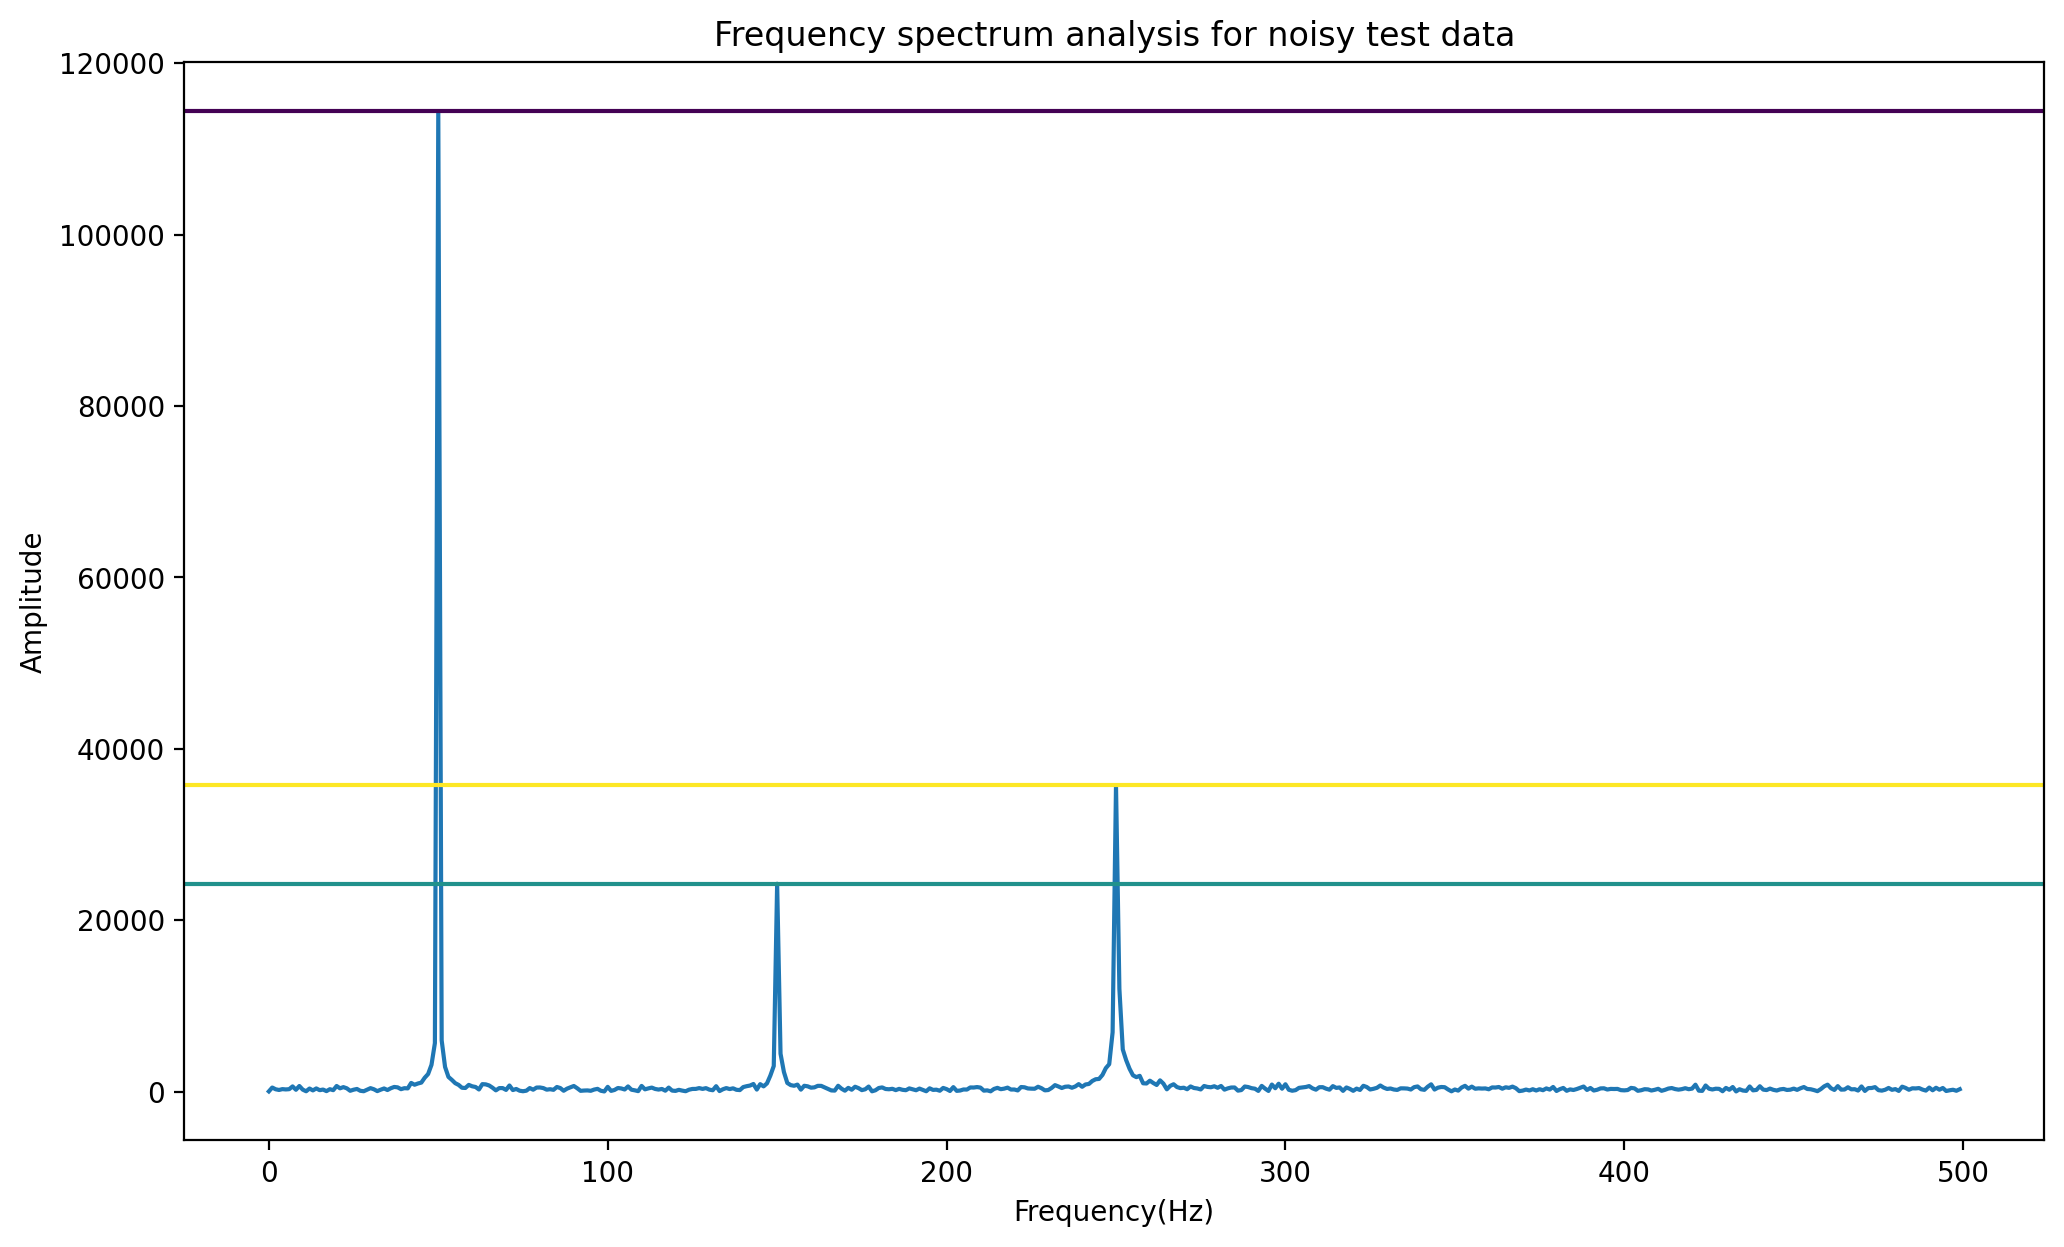

In [ ]:
# plotting and analysis using the synthetic data

x,y = fft_transfrom (t_vec,Noisy_signal,sample_freq) #setting the x and y values to the frequencies and fft lists from fft_transform
interval  = 100
end = 300

Peak_amps = peak_finding(y,interval,end) # calling the peak finding function with a threshold of 20,000

print("the amplitude of the fundemnetal frequency is: " + str(max(Peak_amps))) # prints the highest value from the spectrum analasys (which corresponds to the fundemental frequency)
print("the amplitudes of the harmonics are: " + str (Peak_amps[1-np.argmax(Peak_amps):]) ) # prints all the other values (the harmonics)

# plotting the function
Visualise_freq_spectrum (x,y,Peak_amps)
plt.title("Frequency spectrum analysis for noisy test data")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude")

The function to calculate the THD was also called using the array of peak values and reached a total harmonic distortion of 37.75%. This value will act as our baseline for comparison in the next two steps.

In [ ]:
# calling the THD forumla to calcualte the THD of the synthetic data
print("total harmonic distortion =" ,calc_THD(Peak_amps), "%")




total harmonic distortion = 37.75603454325254 %


With the true THD calculated, the data can be manipulated to remove a certain amount of values to create irregular data as defined in the previous section. There is a complete lack of academic information on the true percentage reliability of voltage sensors in power systems but the main method used to calculate THD is spectral analysis through the Fourier transformation which tells us that the majority of data is evenly spaced and evenly sampled. This implies that sensor failure is very rare. Sources also  indicate that voltage sensors are generally functionally operational due to their cheap construction, making them easy to replace [18]. With these facts in mind the regular_to_irregular function was called with 90% efficiency meaning 90% of the signal will be retained. The code then calls the interpolation function with the new x and y arrays to create a new interpolated signal that is stored in signal_interpolated.

The graph produced below varies each time this code is run as the regular_to_irregular function changes which points get removed randomly.

Text(0, 0.5, 'Voltage(V)')

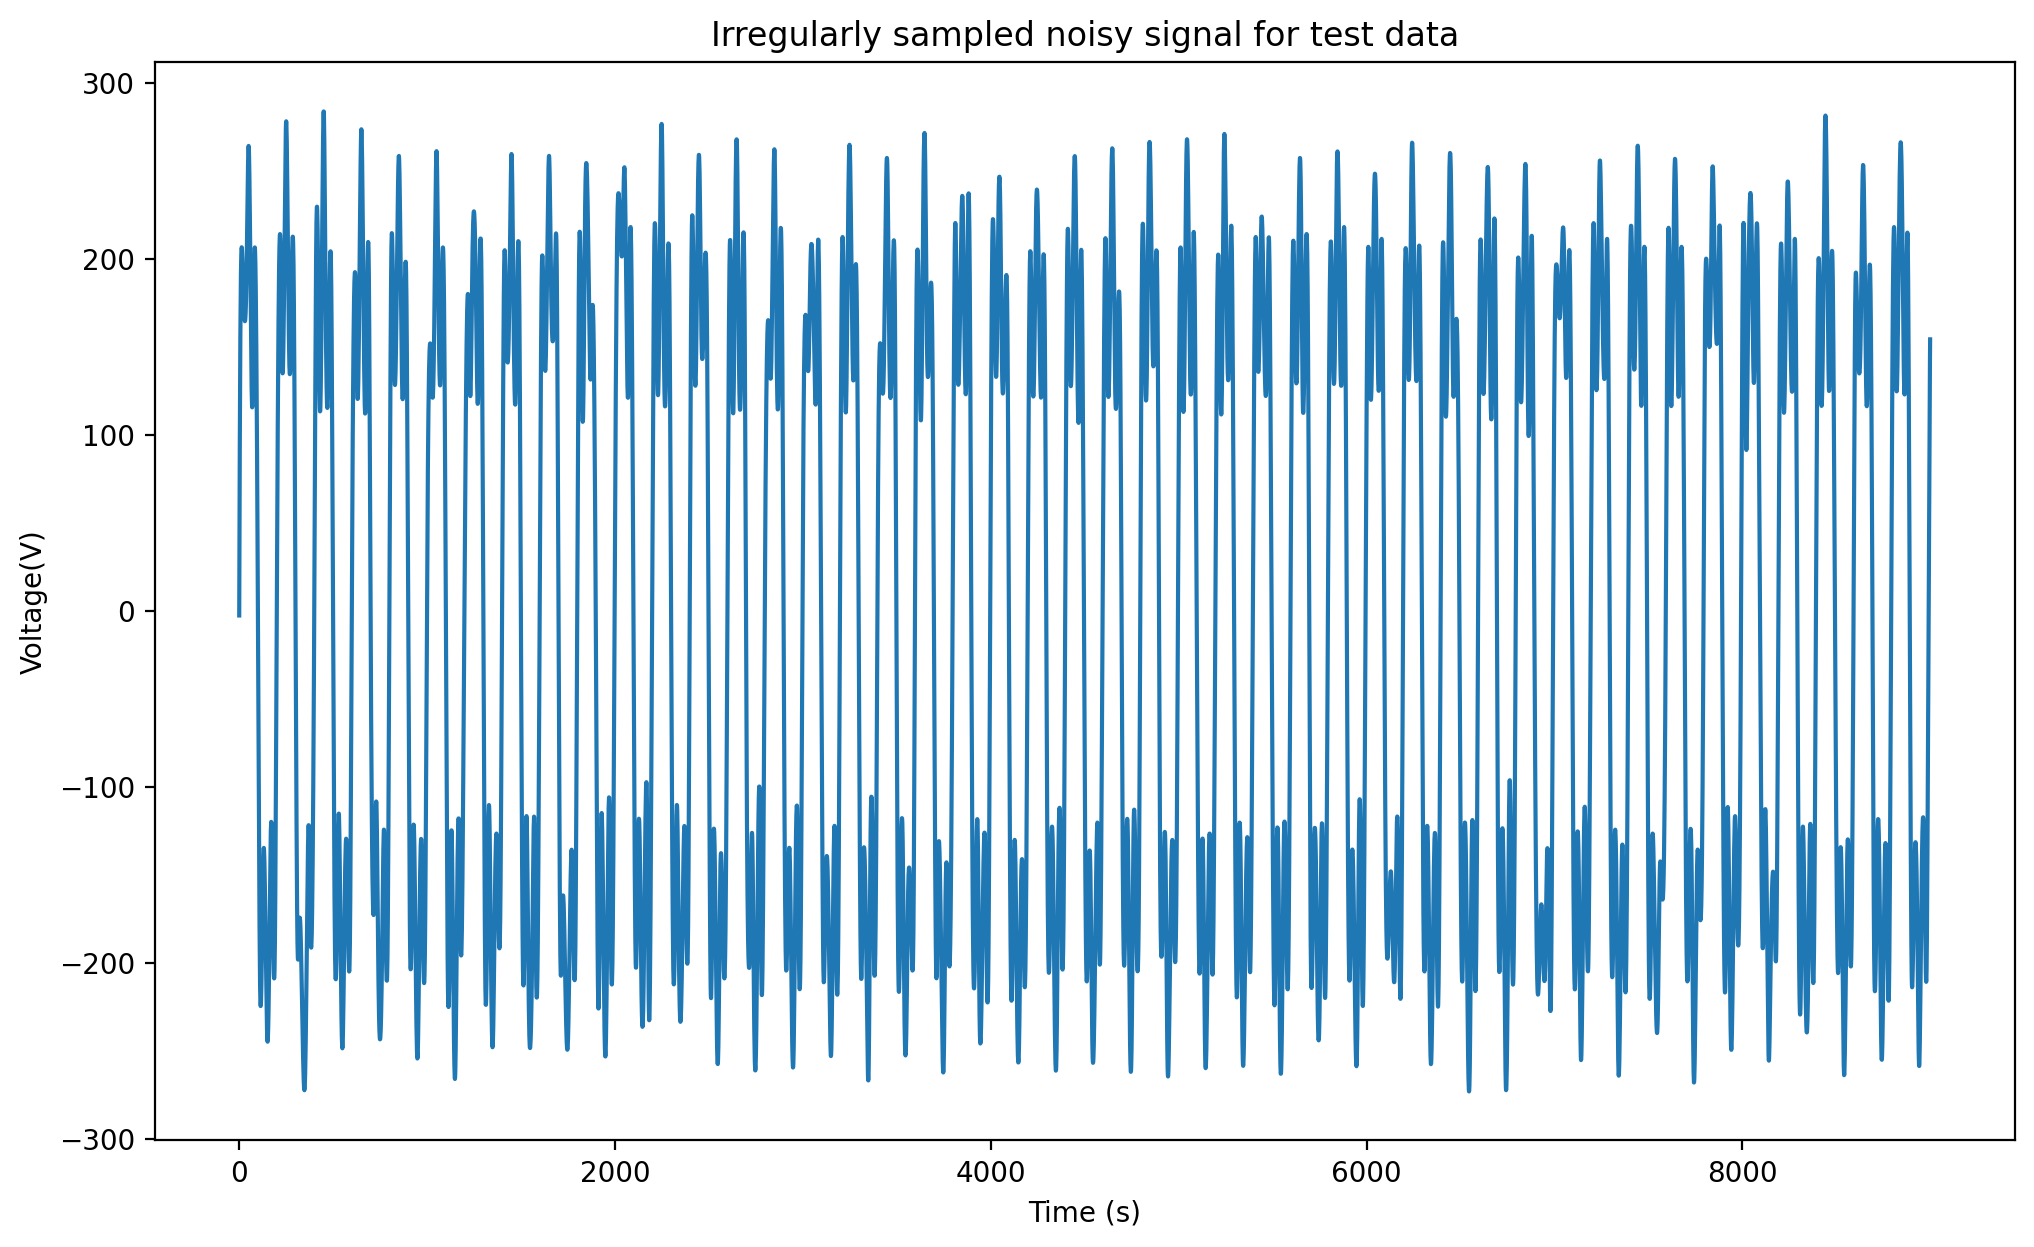

In [ ]:
sample_freq = 1000 # sampling frequency (Hz)
f1 = 50 # fundamental frequency (Hz)
T = 1 # duration (s)

times = np.arange(0,len(Noisy_signal))
values = Noisy_signal

#conversion to irregular sampling
x_irregular,y_irregular = regular_to_irregular (times,values,900)


#interpolation
signal_interpolated = irregular_interpolation(x_irregular,y_irregular)



#time vector
t_vec = np.linspace(0,T,int(sample_freq*T))


plt.plot(signal_interpolated)

plt.title("Irregularly sampled noisy signal for test data")
plt.xlabel("Time (s)")
plt.ylabel("Voltage(V)")

After the signal is interpolated, the values are passed through the same FFT transform function from before with the same parameters being used to find the peaks. There is already a notable difference in the location and values of the peaks as can be seen in the graph below ,However, the general shape and relative positions of the peaks in relation to each other is still consistent.

the amplitude of the fundemnetal frequency is: 1028886.4634236045
the amplitudes of the harmonics are: [218748.25330894915, 310261.9978076052]


Text(0, 0.5, 'Amplitude')

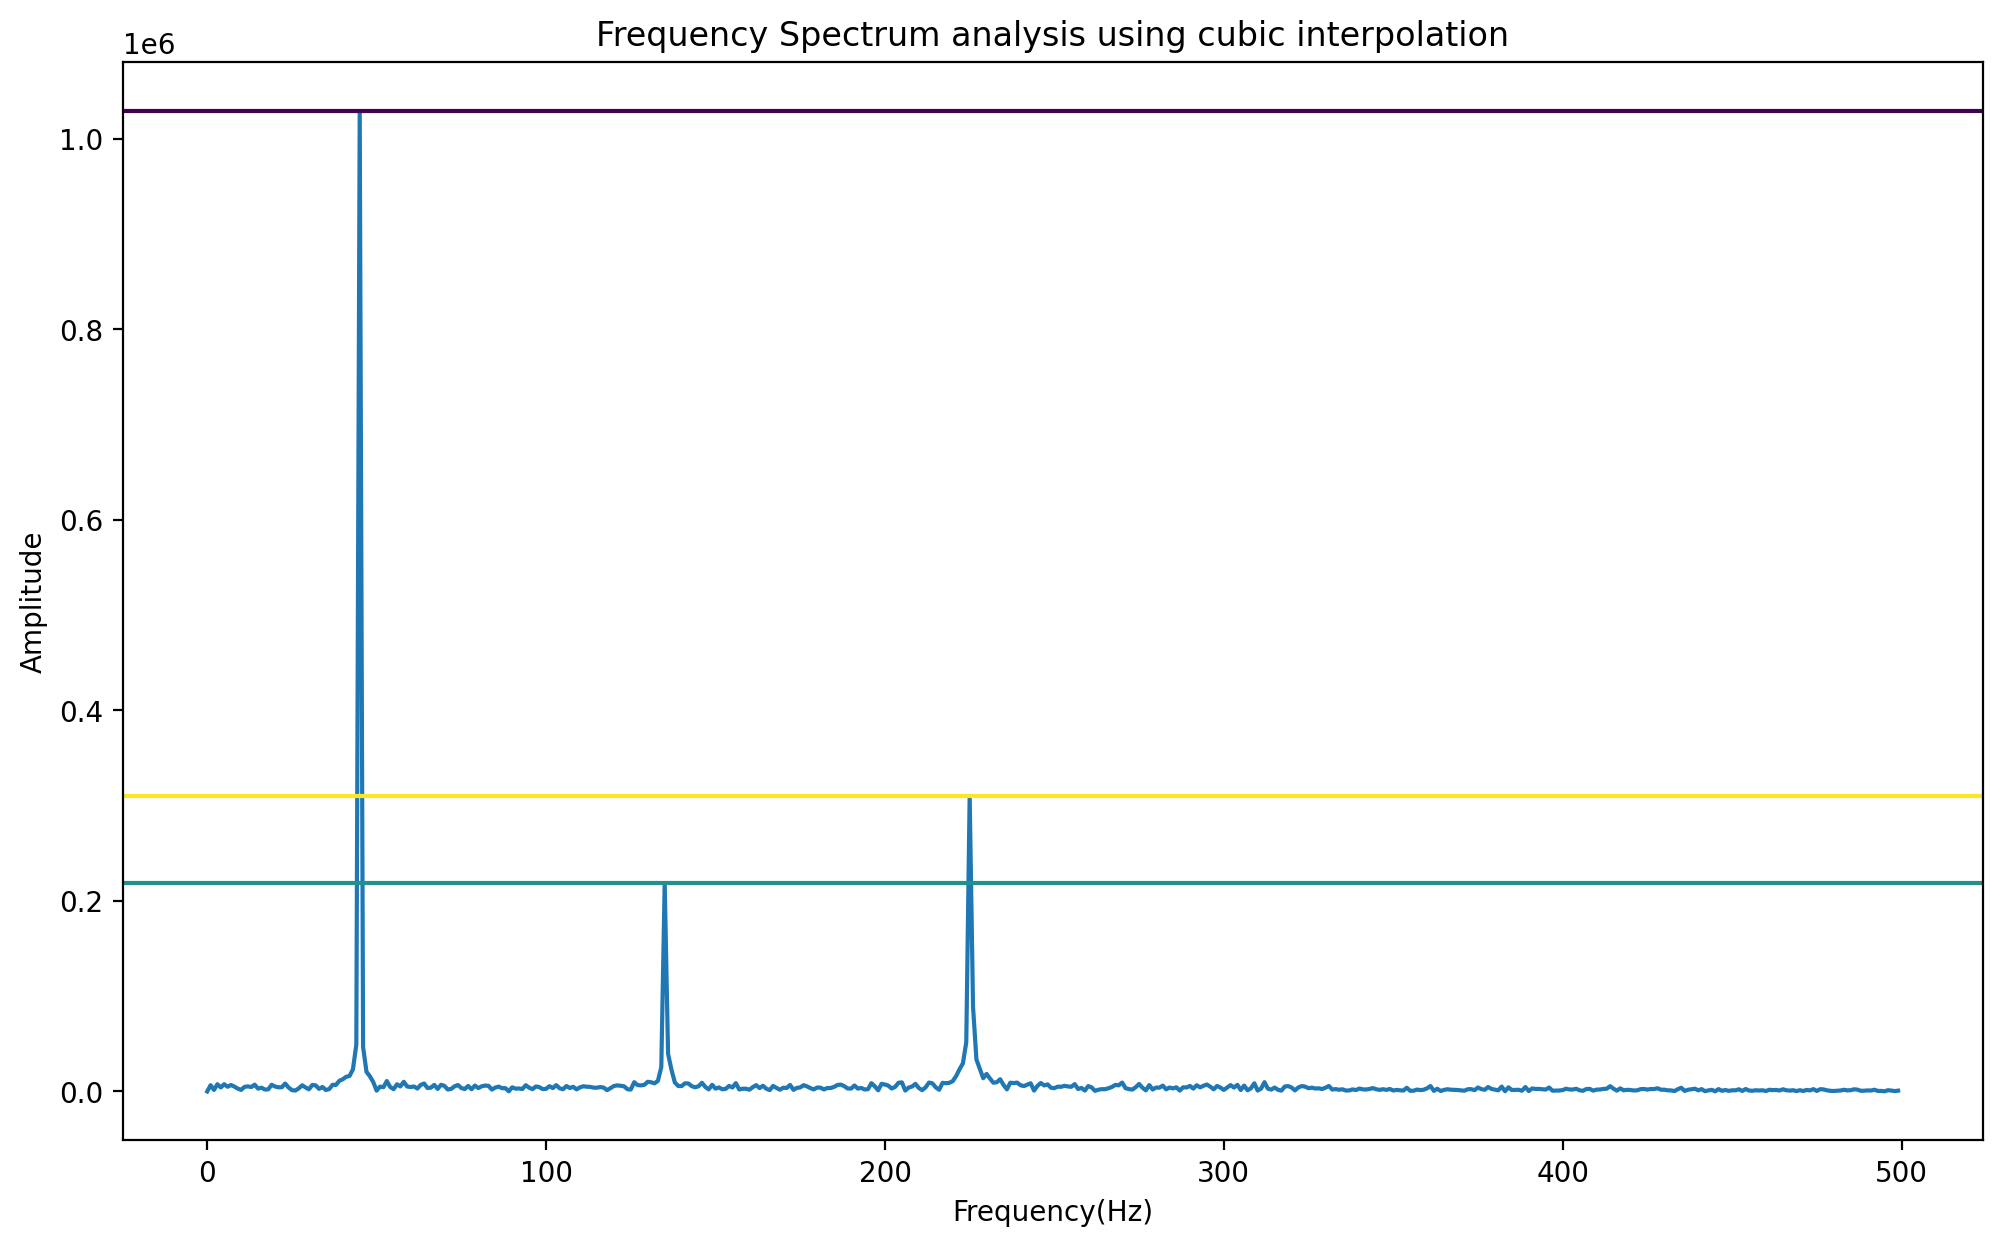

In [ ]:


# plotting and analysis using the synthetic data

x,y = fft_transfrom (t_vec,signal_interpolated,sample_freq) #setting the x and y values to the frequencies and fft lists from fft_transform

interval  = 100
end = 300

Peak_amps = peak_finding(y,interval,end) # calling the peak finding function with a threshold of 20,000

print("the amplitude of the fundemnetal frequency is: " + str(max(Peak_amps))) # prints the highest value from the spectrum analasys (which corresponds to the fundemental frequency)
print("the amplitudes of the harmonics are: " + str (Peak_amps[1-np.argmax(Peak_amps):]) ) # prints all the other values (the harmonics)

# plotting the function
Visualise_freq_spectrum (x,y,Peak_amps)

plt.title("Frequency Spectrum analysis using cubic interpolation")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude")

The THD value from the interpolated graph is called below.

In [ ]:
# calling the THD forumla to calcualte the interpolated THD of the synthetic data
print("total harmonic distortion =" ,calc_THD(Peak_amps), "%")

total harmonic distortion = 36.89645034785223 %


The Lomb-Scargle method is then called using the irregular data. This piece of code was run many times with multiple different parameters to find the ideal ones for this specific set of data. The graph below shows the same general shape as the two above, confirming that the functions operated as intended.

Text(0, 0.5, 'Power(W)')

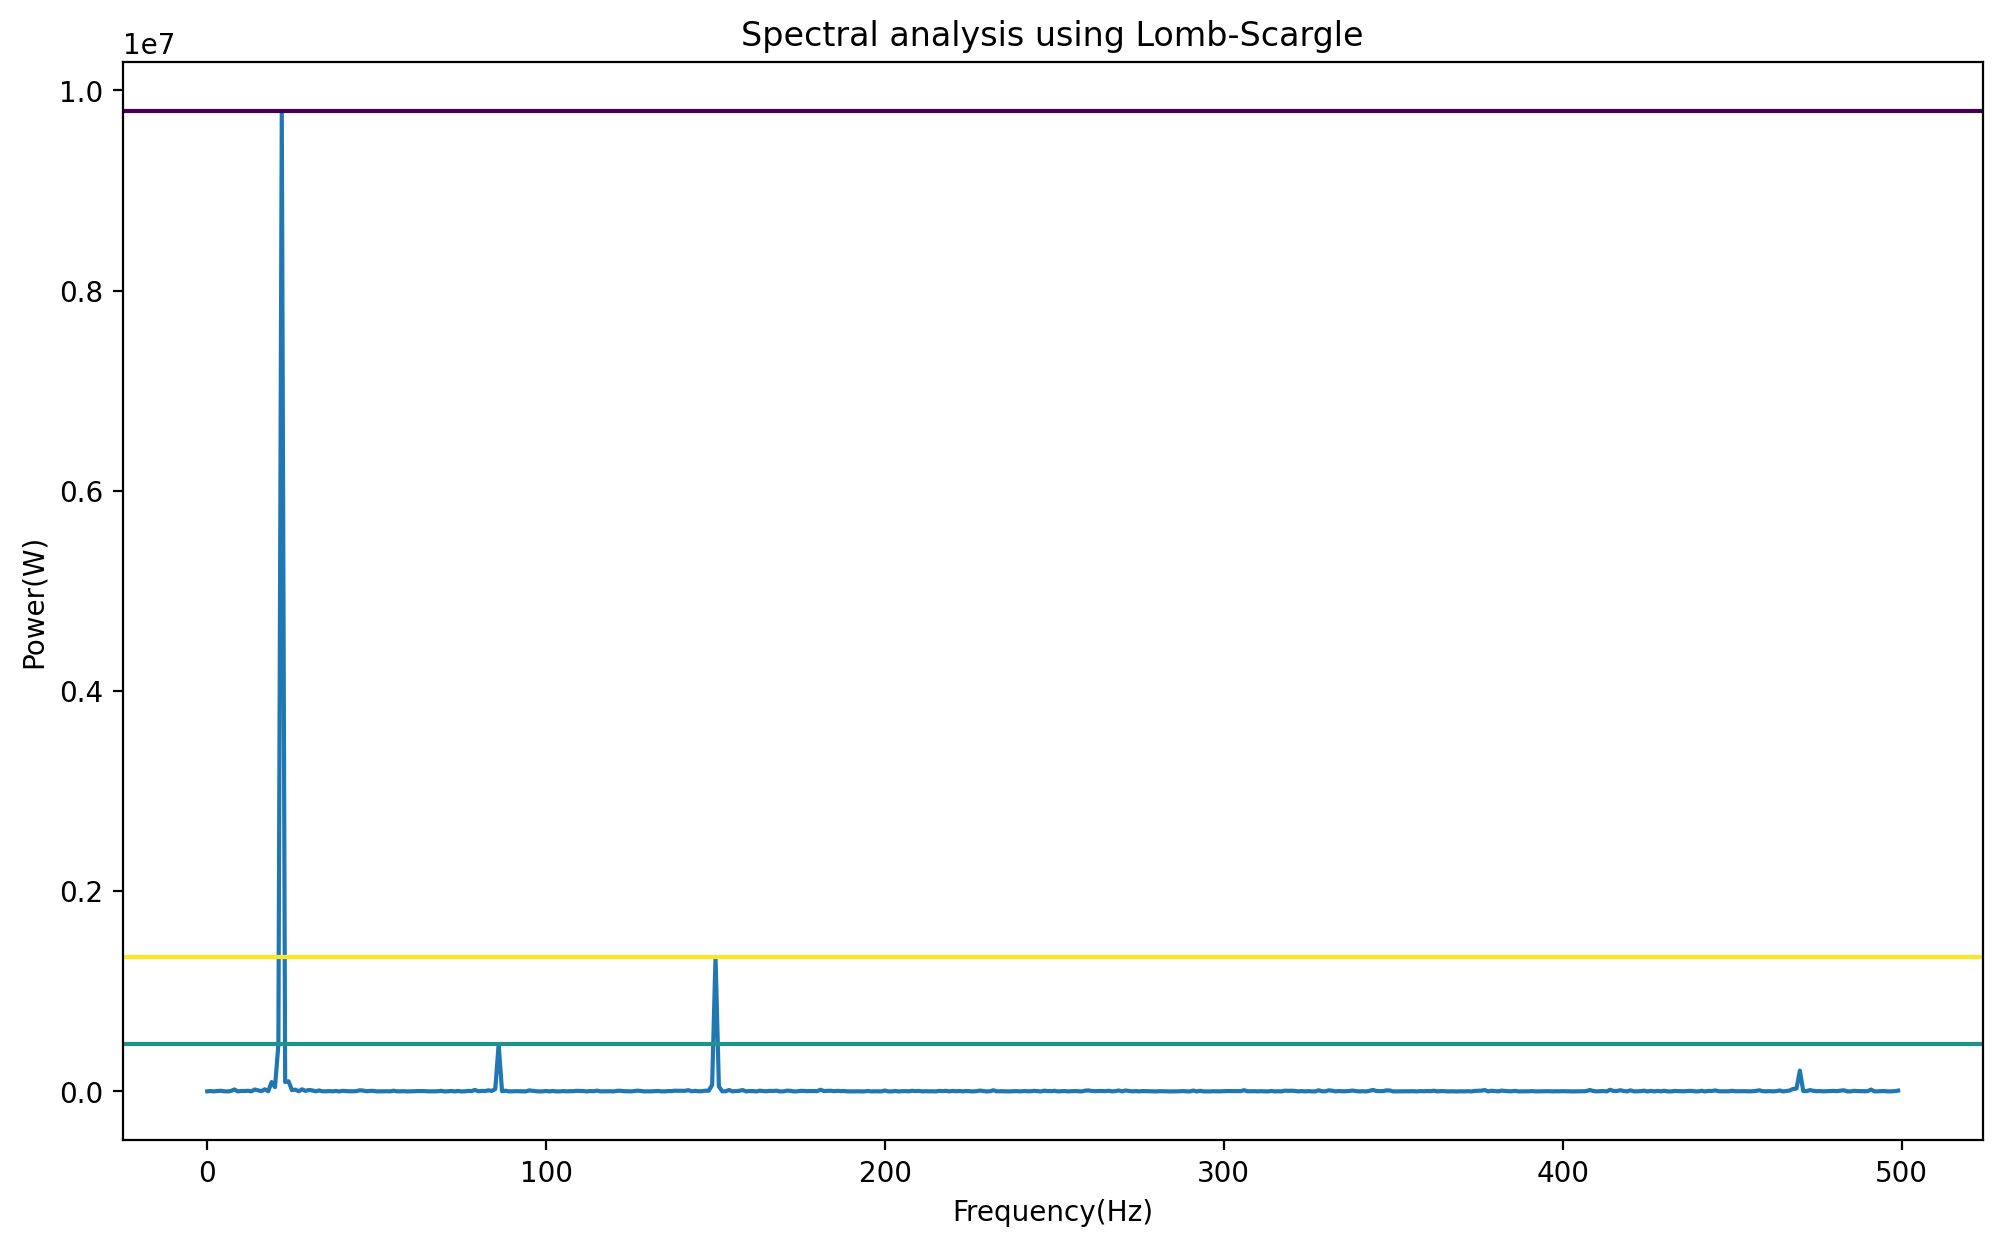

In [ ]:
Peak_amps = Plot_Lomb_Scargle (x_irregular, y_irregular,75,200,5,500,0.1)

plt.title("Spectral analysis using Lomb-Scargle")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Power(W)")

Finally, the THD is calculated using the Power formula.

In [ ]:
TDH_Lomb_Scargle(Peak_amps)

43.056728096047244

During testing, a lot of the values above changed, sometimes drastically, between each subsequent execution of the code. These changes stem from the way the irregular values are computed. Since the regular_to_irregular function uses a random function to pick which values are removed, The calculated THD can vary greatly depending on if a removed value was part of the harmonic peak or not. To minimise this effect on the real dataset in the next section. each THD was calculated 10 times with 10 different sets of values removed. The values were then averaged to produce a more accurate answer.



# 2: Results



# 2.1 : Importing the dataset and calling functions

The data set that will be used in this project is taken from an EV charging system [23]. The data is formatted in a .csv file, which requires it to be imported into the program using pandas. The signal has a duration of 2 seconds and contains 2e6 sets of data points and times. The data fluctuates between positive and negative 300V which is within the operational range of many consumer level systems. The signal also contains noise and at least one relatively major harmonic. The data points are also regularly and evenly sampled over the 2 second interval, producing a clean uninterrupted signal.

The section below highlights the importing and isolation of the data from the csv file as well as the calling of the various functions in the order stated in the method section. The data has also been down-sampled in this section by only recording every other data point. this was done due to limitations in the memory capabilities of the Cocalc server. Running the full data set through the program caused frequent crashes and memory errors.


In [ ]:
#importing the signal

df = pd.read_csv("F08_EV_PLC_Data_V2.csv")



The cells below show the initial FFT performed using the regularly sampled data and the interpolation method as they share the same parameters. The time duration was set to 2 seconds to match the length of the signal and the sampling frequency was declared at 1500Hz to ensure all the larger values present in the frequency spectrum were caught. Based on the number of peaks present in the graph, the interval chosen for the peak finding function was set to 50 and the endpoint was set to 800 as smaller harmonics were present the entire length of the spectrum

The program also prints the fundamental frequency and a list of harmonics that will be used later on.


In [ ]:
#harmonic analysis (regularly sampled data)

T = 2 # duration (s)
sample_freq = 1500

#time vector
t_vec = np.linspace(0,T,int(sample_freq*T))

#converting dataframe to np array
data_column = df.iloc[:, 0]
data_array = data_column.to_numpy()

#downsampling due to limitatons with Cocalc
data_array_downsampled = data_array[::2]
t_vec_downsampled = t_vec[::2]

#parameters for peak finding function
interval  = 50
end = 800

x_initial,y_initial = fft_transfrom (t_vec_downsampled,data_array_downsampled,sample_freq) #setting the x and y values to the frequencies and fft lists from fft_transform
Peak_amps_original = peak_finding(y_initial,interval,end) # calling the peak finding function

print("the amplitude of the fundemnetal frequency is: " + str(max(Peak_amps_original))) # prints the highest value from the spectrum analasys (which corresponds to the fundemental frequency)
print("the amplitudes of the harmonics are: " + str (Peak_amps_original) ) # prints all the other values (the harmonics)


the amplitude of the fundemnetal frequency is: 160166708.8819013
the amplitudes of the harmonics are: [41663.22951988463, 1881626.0954146008, 160166708.8819013, 50150.12668511797, 57722.03568389976, 19258.09903155174, 156604.29152764234, 20108.73996985063, 23481.009804641046, 94693.34987147212, 1753676.562029226, 8249.530836012169, 16430.744043980856, 67384.45273479354, 934345.5115778248]


The data is modified to represent an irregularly sampled signal using a resampling factor of 0.9 which results in an irregularly sampled signal that is 90% complete.

In [ ]:
#converting EV data to irregularly sampled data:

times = np.arange(0,len(data_array_downsampled))
values = data_array_downsampled


x_irregular,y_irregular = regular_to_irregular (times,values,round(0.9*len(data_array_downsampled)))#90% of signal remaining

signal_interpolated = irregular_interpolation(x_irregular,y_irregular)


In [ ]:
# #harmonic analasys (Interpolated data)


x_interpolated,y_interpolated = fft_transfrom (t_vec_downsampled,signal_interpolated,sample_freq)

interval  = 50
end = 800

Peak_amps_interpolated = peak_finding(y_interpolated,interval,end)

print("the amplitude of the fundemnetal frequency is: " + str(max(Peak_amps_interpolated))) # prints the highest value from the spectrum analasys (which corresponds to the fundemental frequency)
print("the amplitudes of the harmonics are: " + str (Peak_amps_interpolated[1-np.argmax(Peak_amps_interpolated):]) ) # prints all the other values (the harmonics)


the amplitude of the fundemnetal frequency is: 1441609868.6740792
the amplitudes of the harmonics are: [375575.82336081075, 1441609868.6740792, 1666480.6682729884, 332868.85367304395, 518587.3221192834, 1409794.2255049783, 179966.16916693802, 209235.09050727848, 797809.6528641646, 15822456.01353425, 87399.52756507156, 150653.8727299938, 8431223.915286014, 81499.09953863684, 159088.76527986184]


# 2.2 : Graphical and numerical data

Text(0, 0.5, 'Voltage(V)')

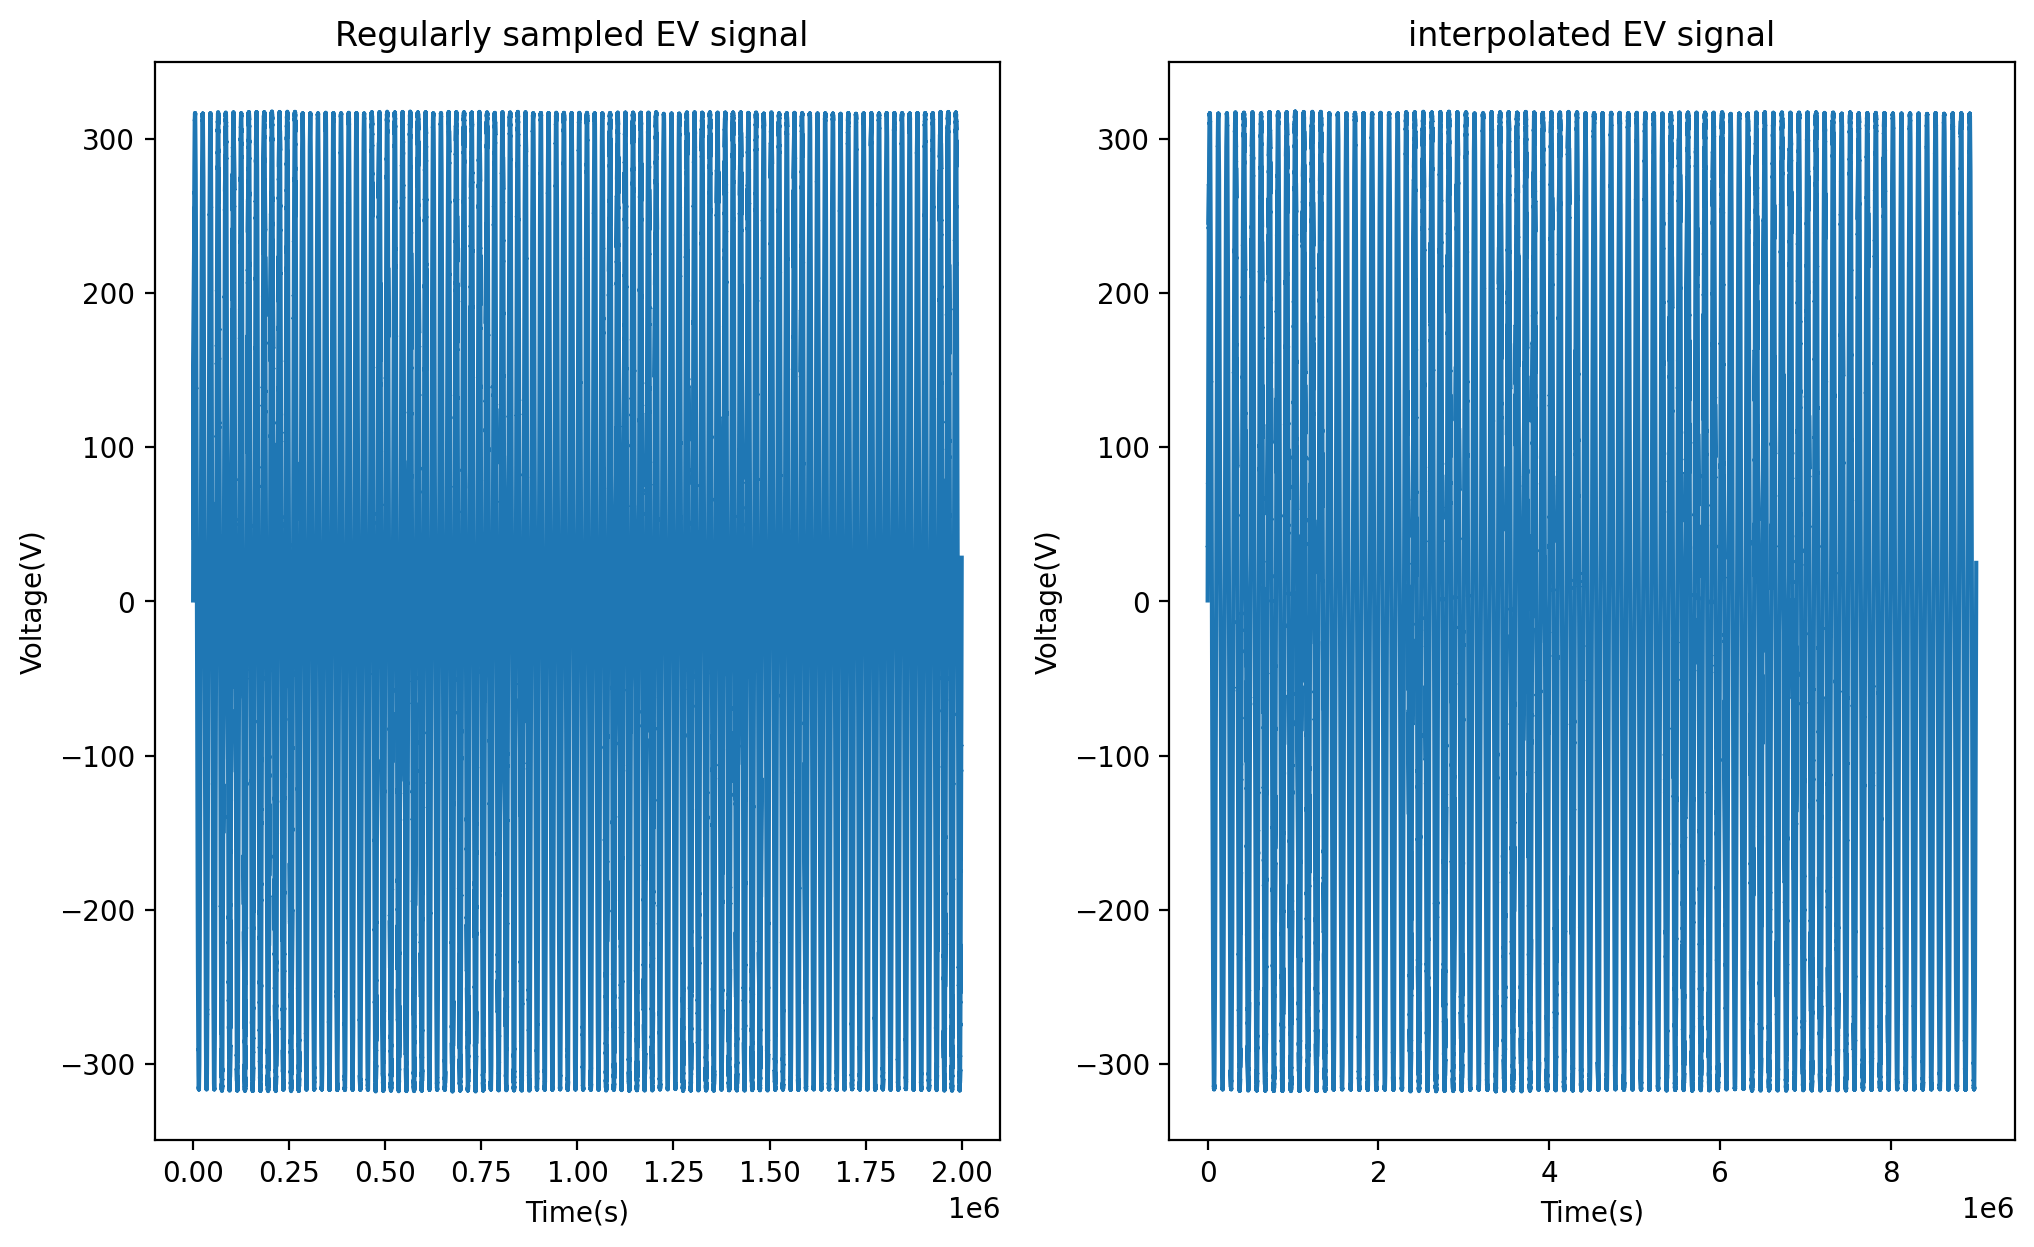

In [ ]:
#waveform representation of signals:

#initial data (regularly sampled)
plt.subplot(1,2,1)
plt.plot(df)

plt.title("Regularly sampled EV signal ")
plt.xlabel("Time(s)")
plt.ylabel("Voltage(V)")



#interpolated signal
plt.subplot(1, 2, 2)
plt.plot(signal_interpolated)

plt.title("interpolated EV signal")
plt.xlabel("Time(s)")
plt.ylabel("Voltage(V)")

The graphs above are sinusoidal representations of the initial signal (left) and the 90% complete signal that was reconstructed using cubic interpolation (right).

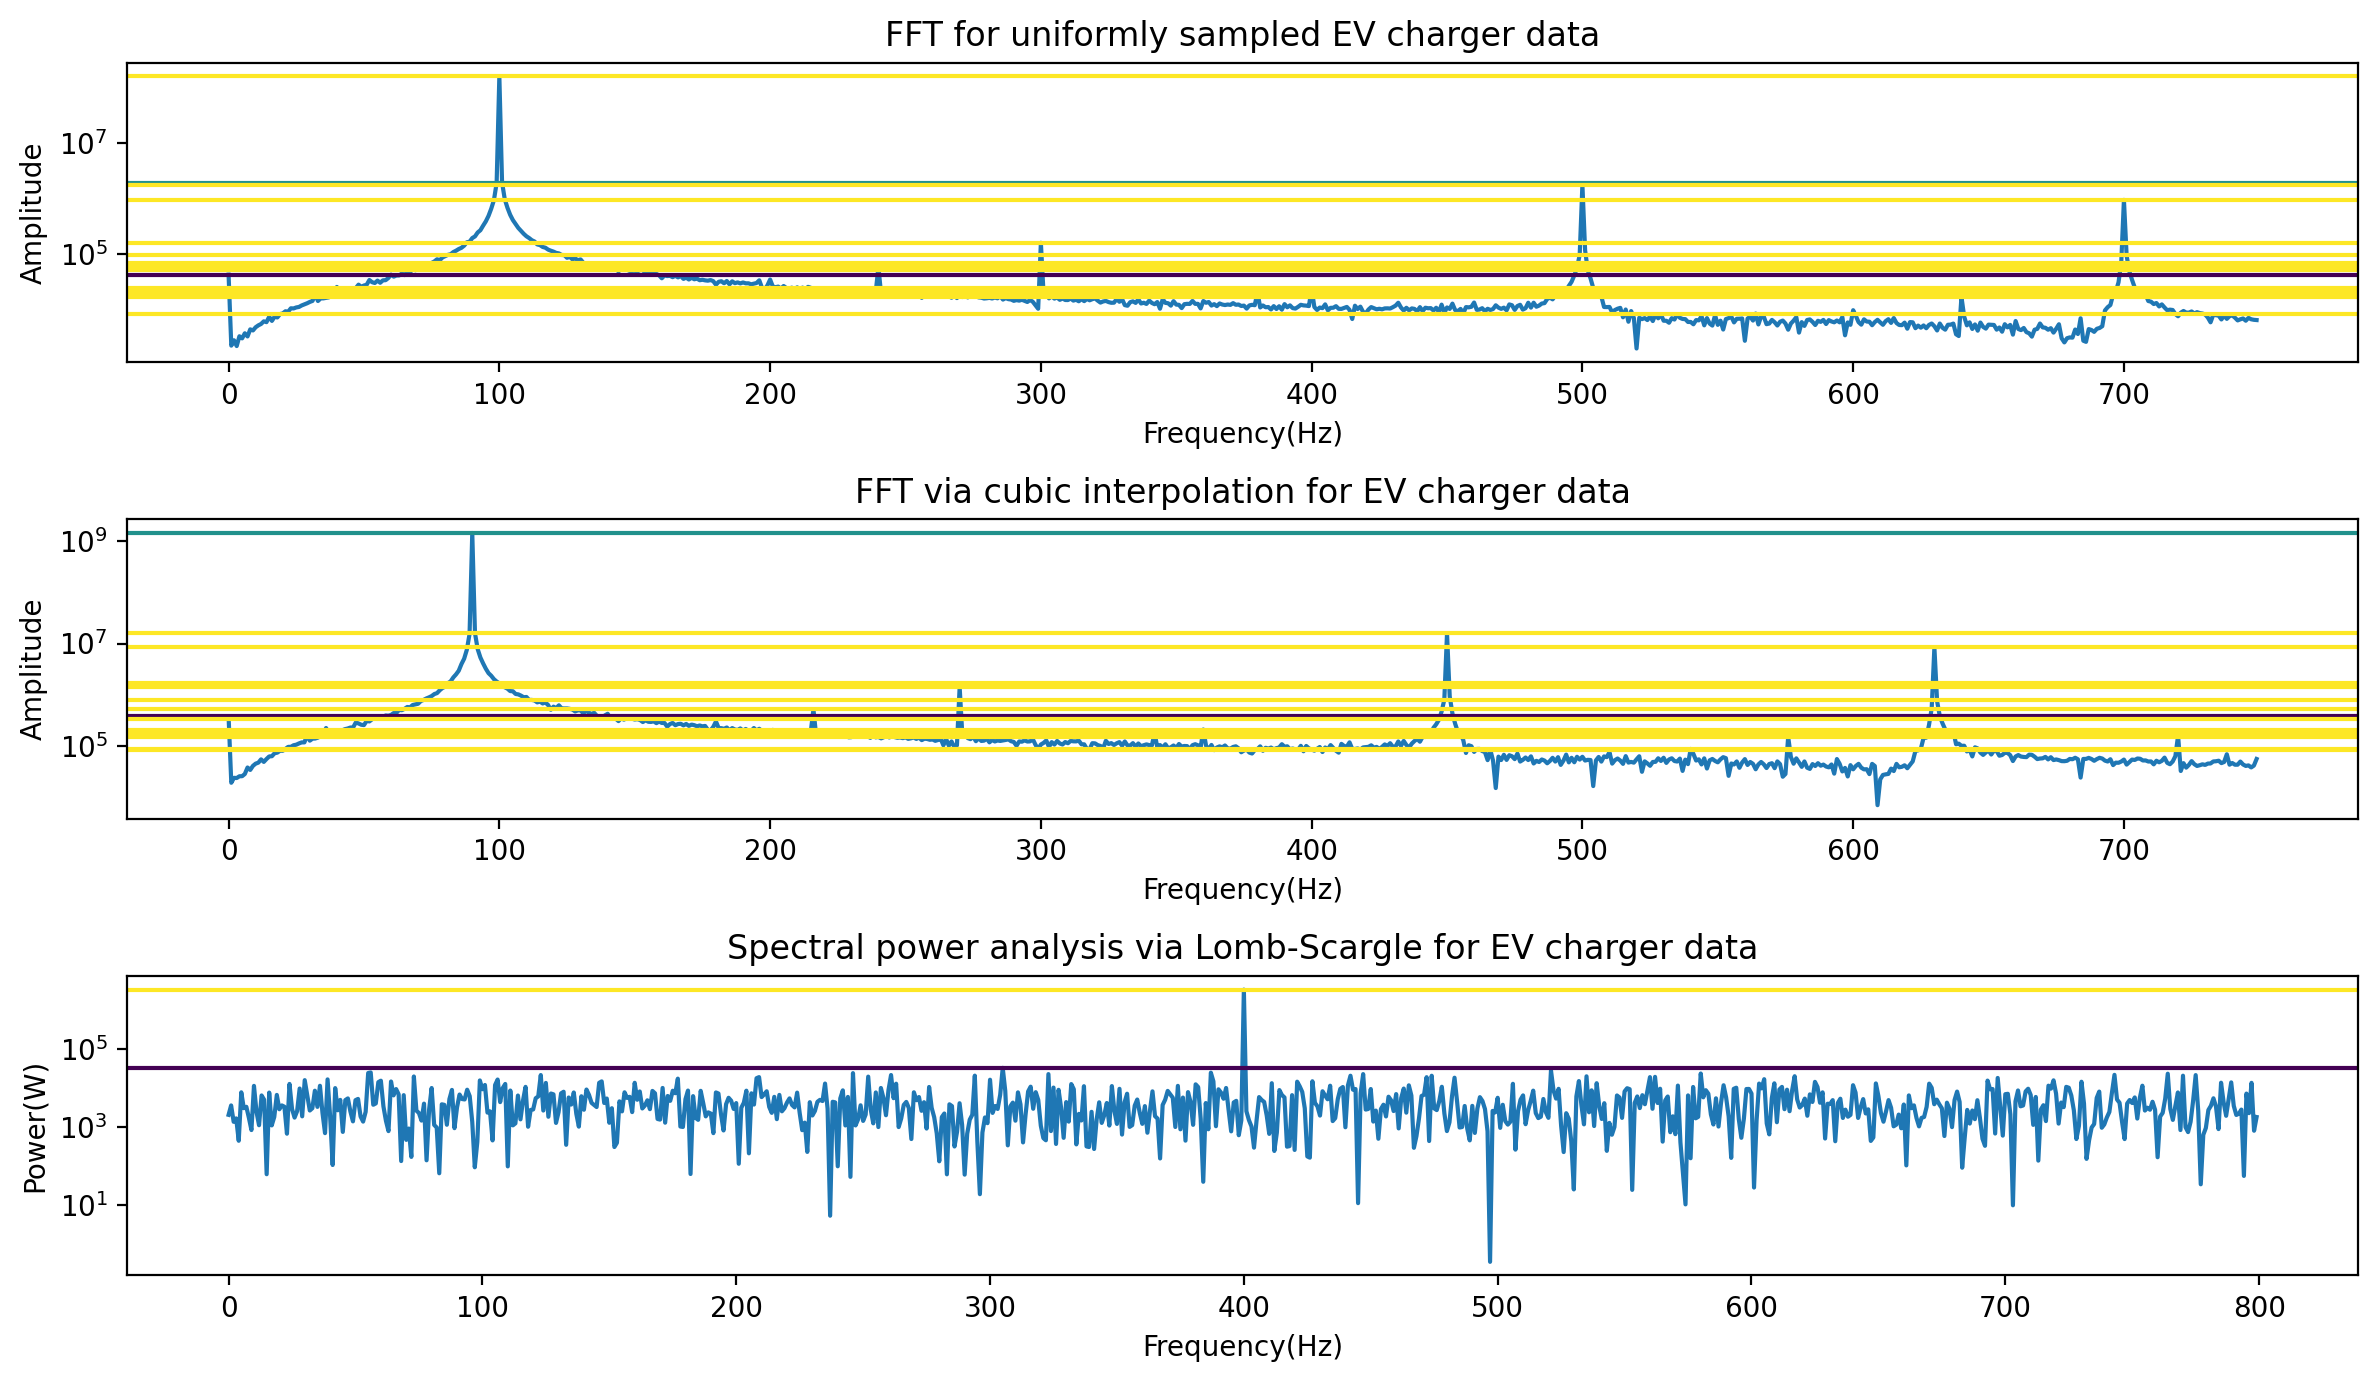

In [ ]:
# specrial analysis graphs

# initial function
plt.subplot(3,1,1)

Visualise_freq_spectrum (x_initial,y_initial,Peak_amps_original)
plt.yscale('log')

plt.title("FFT for uniformly sampled EV charger data")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude")

# interpolated function
plt.subplot(3,1,2)

Visualise_freq_spectrum (x_interpolated,y_interpolated,Peak_amps_interpolated)
plt.yscale('log')

plt.title("FFT via cubic interpolation for EV charger data")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude")


#Lomb-Scargle Function
plt.subplot(3,1,3)
L_S_peak_amps = Plot_Lomb_Scargle (x_irregular, y_irregular,400,800,25,800,0.1)
plt.yscale('log')
plt.title("Spectral power analysis via Lomb-Scargle for EV charger data")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Power(W)")



plt.tight_layout()

The sublots in the section above show the three different graphs produced by the initial FFT and the two methods that are being compared for irregular sampling. The graphs also display horizontal lines marking each harmonic and show a lograthmic scale on the y axis due to the large range of the data.

In [ ]:
# final THD values

print("TDH results: ")

#THD of the initial data
print("total harmonic distortion (initial data) =" ,calc_THD(Peak_amps_original), "%")

# THD of the interpolated data
print("total harmonic distortion (interpolated data) =" ,calc_THD(Peak_amps_interpolated), "%")

#THD of Lomb-Scargle data
print("total harmonic distortion (Lomb-Scargle) =" ,TDH_Lomb_Scargle(L_S_peak_amps), "%")

TDH results: 
total harmonic distortion (initial data) = 1.7139705879869678 %
total harmonic distortion (interpolated data) = 1.2553224696749528 %
total harmonic distortion (Lomb-Scargle) = 9.831942963567267 %


The THD outcomes from a single iteration of the code are displayed above as percentages, Due to the random nature of the code, results from 10 consecutive iterations That were performed earlier are listed in the cell below with the average values calculated for each method.

In [ ]:
Initial_values = [1.7139705879869678,1.7139705879869678,1.7139705879869678,1.7139705879869678,1.7139705879869678,1.7139705879869678,1.7139705879869678,1.7139705879869678,1.7139705879869678,1.7139705879869678]
Interpolated_values = [1.2553189654864907,1.2553222661551133,1.2553152483784438,1.2553226876034465,1.2553150652249432,1.2553118527778315,1.255315684409893,1.2553274504943364,1.2553115101445882,1.2553224078923306]
Lomb_Scargle_values =[33.99131998225901,8.723590153311816,11.009346167670229,9.783837987827953,10.990905434409944,10.399462396467586,14.141708944648842,9.268111856067742,10.435722207129219,12.187957160311292]

#titles
print("{:^10}  {:^10}   {:^10}".format("Initial","Interpolated","Lomb-Scargle"))

#values
for i in range (len(Initial_values)):
    print("{:^10}  {:^10}   {:^10}".format(Initial_values[i],Interpolated_values[i],Lomb_Scargle_values[i]))

print (" ")
#averages
print("{:^10}  {:^10}   {:^10}".format(sum(Initial_values)/10,sum(Interpolated_values)/10,sum(Lomb_Scargle_values)/10))

 Initial    Interpolated   Lomb-Scargle
1.7139705879869678  1.2553189654864907   33.99131998225901
1.7139705879869678  1.2553222661551133   8.723590153311816
1.7139705879869678  1.2553152483784438   11.009346167670229
1.7139705879869678  1.2553226876034465   9.783837987827953
1.7139705879869678  1.2553150652249432   10.990905434409944
1.7139705879869678  1.2553118527778315   10.399462396467586
1.7139705879869678  1.255315684409893   14.141708944648842
1.7139705879869678  1.2553274504943364   9.268111856067742
1.7139705879869678  1.2553115101445882   10.435722207129219
1.7139705879869678  1.2553224078923306   12.187957160311292
 
1.7139705879869678  1.2553183138567419   13.093196229010363


# 3 : Discussion

The first step when looking over the results is to look at the feasibility of the baseline value to determine if the original signal was correctly processed and analyzed. As can be seen in the table from the results section, the initial THD stayed consistent at 1.71% due to the initial data not being affected by the random module yet. Looking at this number in the context of a real world power system, the data that was used in this project comes from an American source. This means that we can use the IEEE guidelines on harmonic distortion which states that all commercial power systems must retain a THD >5%.[19] Additionally, while some sources do state that the harmonic distortion can change significantly during a charge cycle, it is possible for a commercial system to run with a THD as low as 1%.[20] Considering these two facts, It is entirely possible that the EV system in our project could run with a THD of 1.71% .

When comparing the averages for the two methods, there is a very obvious error present in the results from the Lomb -Scargle power analysis. The results from the interpolated data are very consistent with the first five digits of each iteration being the same however, the results from the Lomb-Scargle method are extremely varied with the highest result being 33.99% and the lowest result being 8.72% leading to an average of 13.09% which is substantially larger than the expected value. The cell below executes a function that displays the percentage error for both results:


In [ ]:
#Percentage error calculation

def errors (average,expected):

    return ((average - expected) / (expected))*100 #returns error


#output
print ("Interpolation percentage error : " + str(abs(errors (1.2553183138567419,1.7139705879869678))) + " %")

print ("Lomb-Scargle percentage error : " + str(abs(errors (13.093196229010363,1.7139705879869678))) + " %")



Interpolation percentage error : 26.759635045365975 %
Lomb-Scargle percentage error : 663.9102048062636 %


The value obtained by cubic interpolation is much closer to the expected value with a percentage error of 27% which initially looks like a high percentage error, but in practise still returns a value that is >5%, keeping it well within the range of acceptable .The Lomb-Scargle method returns an error of 664%. This indicates that the Lomb-Scargle method completely failed, returning a value that incorrectly represents the starting signal. When analyzing the spectral graphs produced by the three methods , the original FFT and interpolated FFT are shown to depict similar shapes with a prominent peak at ~100 Hz and two more smaller peaks between 400Hz and 700Hz. However, the spectral power analysis produced by the Lomb-Scargle function shows a graph with large amounts of noise and a singular peak around 400Hz which is inconsistent with both the other graphs. This result is anomalous as all the graphs from the method section that displayed the spectral data for the synthetic dataset shared the same overall shape with a Large leading peak at ~50Hz followed by two smaller peaks. This comparison shows that the issue might lie with the data and not the function.

There are a few reasons why the Lomb-Scargle might have failed. The most likely reason is due to the limitations of the Cocalc platform. As stated in the results section, the EV charger data had to be down sampled, with alternate values being used for the FFT. The reduction in data points can distort the data and cause an inaccurate plot, especially if the maximum and minimum frequency limits are incorrectly set. [21] This also highlights a potential weakness in the code as the upper and lower frequency limits were manually calculated and set which could result in an incorrect set of values being used.

In [ ]:
# percentage difference based on the Synthethetic data

def errors (average,expected):

    return ((average - expected) / (expected))*100 #returns error


#output
print ("Interpolation percentage error : " + str(abs(errors (35,38))) + " %")

print ("Lomb-Scargle percentage error : " + str(abs(errors (46,38))) + " %")

Interpolation percentage error : 7.894736842105263 %
Lomb-Scargle percentage error : 21.052631578947366 %


Returning to the overall comparison, data taken from a single run of the synthetic set, shows that the Interpolation method still resulted in a more accurate THD value. One possible reason for this could stem from the peak finding algorithm. The current algorithms is rather simple  not take the noise floor into consideration, resulting in scenarios where it may incorrectly identify a noisy element as a harmonic value. This phenomenon is less visible in the synthetic data set as the peaks are clearly defined and differentiated from the noise floor.  Another reason for the differences between the values may be due to the makeup of the irregularly sampled signal. As the majority (90%) of the original signal is intact, it is very easily reconstructed using cubic interpolation as the majority of the data points still exist. Under these circumstances, cubic interpolation is a more reasonable method to use on these this data sets as it is computationally cheaper than the Lomb - Scargle. Additionally, the interpolation method uses the exact same FFT function used for the original data which further minimises the error between the results from the initial data and the interpolated data. Similarly, as both methods use the same FFT function, they both produce graphs with the same variables on each axis allowing the TDH to be calculated using the same function as before too. This overlap of resources needed between the two methods would be much cheaper to use at an industrial scale over creating a new algorithm. Both methods share one key weakness however as neither of them work particularly well if the missing points are centered around the fundamental or harmonic frequencies. This can be clearly seen on the results graph for the interpolation method as the peaks are slightly shifted to the left, indicating the absence of some harmonic values.

# 4 : Conclusion

Overall, The comparatively lower percentage error of 26.76% and 7.9% for the EV and synthetic data sets clearly indicate that the linear interpolation method is more reliable and useful over the Lomb-Scargle under the specific circumstances produced in this project. As previously stated, the Lomb-Scargle method failed to return a remotely accurate value for the EV dataset, an error that could have been caused by the incorrect use of the function or unsuitable data. However, the Cubic interpolation method proved to be computationally efficient and generally reliable, producing results with a higher degree of consistency and accuracy. Both methods have their place in electrical engineering with other studies stating that the Lomb - Scargle is more useful when the data is more uniform and contains less data points. One of the major sources of error identified was the Peak_finding algorithm which proved to work well on simple data sets with clearly known and defined peaks but was not as effective on the real data set as it could not account for the level of noise present. Further improvements on this algorithm could include high and low pass filters to reduce the amount of unwanted frequencies in the signal and better peak finding methods that can function when the peaks are closer to the noise floor.Similarly, other methods of producing Spectral graphs such as the wavelet transform could be used on these data sets as there may be a method that is more efficient than both of the methods investigated here.

One of the biggest limitations of this project was the data used. The scope of this project was quite narrow, only focusing on a single data set under a single set of conditions. While the Lomb - Scargle did not perform well under these conditions, many studies show that is a more robust and accurate method of producing spectral diagrams. To conclusively decide which method is objectively better, a more varied collection of data sets stemming from different sources and under different environmental conditions should be used. Further research could be conducted using the same data set too by changing the amount of the signal that is retained in the regular_to_irregular function. Additional areas of related research could aim to originally start with an irregularly sampled data set for more accuracy or investigate how other environmental factors could affect the THD.

Similarly, improvements to the code could also be made in future iterations. The two biggest areas of uncertainty in this project was the calculation of the Lomb-Scargle parameters, and the random removal of data in regular_to_irregular. Improvements to the calculation of parameters could include creating a new function to return more precise parameters using the Nyquist theorem [22]. The random function in regular_to_irregular could also be modified to run using a set random seed ensuring the same values get removed each time the program is run. This would allow users to adjust which data points get altered by changing the seed allowing researchers to test both algorithms under different conditions.


# 5 : References

[1] Alexandra von Meier (2006). Electric Power Systems. John Wiley & Sons.

[2] Rao, R., Sahoo, G.S. and Bhawna Saraswat (2024). Investigating the Effects of Power System Harmonics on EMC in Industrial Environments. 2022 13th International Conference on Computing Communication and Networking Technologies (ICCCNT), [online] pp.1–6. doi:https://doi.org/10.1109/icccnt61001.2024.10725487.

[3] Arranz-Gimon, A., Zorita-Lamadrid, A., Morinigo-Sotelo, D. and Duque-Perez, O. (2021). A Review of Total Harmonic Distortion Factors for the Measurement of Harmonic and Interharmonic Pollution in Modern Power Systems. Energies, 14(20), p.6467. doi:https://doi.org/10.3390/en14206467.

[4] Mog, G.E. and Ribeiro, E.P. (2005). Total harmonic distortion calculation by filtering for power quality monitoring. [online] doi:https://doi.org/10.1109/tdc.2004.1432452.

[5] Aghaee, F., Mahdian Dehkordi, N., Bayati, N. and Karimi, H. (2022). A distributed secondary voltage and frequency controller considering packet dropouts and communication delay. International Journal of Electrical Power & Energy Systems, 143, p.108466. doi:https://doi.org/10.1016/j.ijepes.2022.108466.

 [6] Hocke, K., and N. Kämpfer. “Gap Filling and Noise Reduction of Unevenly Sampled Data by Means of the Lomb-Scargle Periodogram.” Atmospheric Chemistry and Physics, vol. 9, no. 12, 24 June 2009, pp. 4197–4206, https://doi.org/10.5194/acp-9-4197-2009.

[7] ENGINEERING, IN. “Introductory Mathematics for Engineering Applications.” O’Reilly Online Learning, 2024, www.oreilly.com/library/view/introductory-mathematics-for/9781118141809/Text/chap006.xhtml?.

[8] Singh, G. K. “Power System Harmonics Research: A Survey.” European Transactions on Electrical Power, vol. 19, no. 2, Mar. 2009, pp. 151–172, https://doi.org/10.1002/etep.201.
 [9] Jain, Sachin K., and S.N. Singh. “Harmonics Estimation in Emerging Power System: Key Issues and Challenges.” Electric Power Systems Research, vol. 81, no. 9, Sept. 2011, pp. 1754–1766, https://doi.org/10.1016/j.epsr.2011.05.004.

[10] Michael Cerna and Audrey F. Harvey, National instruments, “Application note 401” accessible as pdf:https://www.sjsu.edu/people/burford.furman/docs/me120/FFT_tutorial_NI.pdf?

[11] Portillo, Francisco, et al. “Estimation of the Total Current Harmonic Distortion Using an ELF Magnetometer.” Sensors and Actuators A: Physical, vol. 371, 7 Mar. 2024, p. 115255, www.sciencedirect.com/science/article/pii/S0924424724002486, https://doi.org/10.1016/j.sna.2024.115255.

[12] VanderPlas, Jacob T. “Understanding the Lomb–Scargle Periodogram.” The Astrophysical Journal Supplement Series, vol. 236, no. 1, 11 May 2018, p. 16, https://doi.org/10.3847/1538-4365/aab766.


[13] “Scipy.interpolate.interp1d — SciPy V1.10.1 Manual.” Docs.scipy.org, docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html.

[14] Vio, R., et al. “Irregular Time Series in Astronomy and the Use of the Lomb–Scargle Periodogram.” Astronomy and Computing, vol. 1, Feb. 2013, pp. 5–16, https://doi.org/10.1016/j.ascom.2012.12.001.

[15] A. Ya. Sidorin. “Features of the Diurnal Periodicity of Earthquakes in Japan.” Seismic Instruments, vol. 50, no. 3, 1 July 2014, pp. 246–267, https://doi.org/10.3103/s0747923914030098.

[16] Singh, Hemant. “A K.Sawhney-A Course in Electrical and Electronic Measurements and Instrumentation.” Academia.edu, 30 Aug. 2014, www.academia.edu/8140873/A_K_Sawhney_A_course_in_Electrical_and_Electronic_Measurements_and_Instrumentation.


[17] Aktif. “Origin of Electric Frequencies and the Use of 50 Hz and 60 Hz.” Aktif, 18 Mar. 2023, aktif.net/en/origin-of-electric-frequencies-and-the-use-of-50-hz-and-60-hz/.


[18] “Voltage Sensor - an Overview | ScienceDirect Topics.” Www.sciencedirect.com, www.sciencedirect.com/topics/engineering/voltage-sensor.

[19] Das, J C. “Harmonic Distortion Limits according to Standards.” John Wiley & Sons, Inc. EBooks, 6 Mar. 2015, pp. 427–451, https://doi.org/10.1002/9781118887059.ch10.

[20] “Harmonic Measurement and Analysis during Electric Vehicle Charging.” Power Quality Blog , 15 Mar. 2024, powerquality.blog/2024/03/15/harmonic-measurement-and-analysis-during-electric-vehicle-charging/.

[21] Stewart, Jill, et al. “Application of the Lomb-Scargle Periodogram to InvestigateHeart Rate Variability during Haemodialysis.” Journal of Healthcare Engineering, vol. 2020, 8 Dec. 2020, pp. 1–18, www.ncbi.nlm.nih.gov/pmc/articles/PMC7738214/, https://doi.org/10.1155/2020/8862074.

[22] ---. “Understanding the Lomb–Scargle Periodogram.” The Astrophysical Journal Supplement Series, vol. 236, no. 1, 11 May 2018, p. 16, https://doi.org/10.3847/1538-4365/aab766.

[23] “Waveform Library - SupraEMI.” SupraEMI, 2021, empir.npl.co.uk/supraemi/waveform-library/